# Lab 7: 提升法(Boosting)-- 分类

## 导入电信客户流失数据

In [1]:
import os
import sys
import pandas as pd

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from common.filesio import FilesIO
data = pd.read_csv(FilesIO.getLectureData('Telco-Customer-Churn.csv'))
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### TotalCharges 数据类型不对，需转变成数值形式

In [2]:
# Converting Total Charges to a numerical data type.
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')  ## errors='coerce': 无效的值将被设为NaN
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### 去掉含有NaN的行（实例）

In [3]:
# drop missing cases
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. 设定输出Y和特征X

### 1.1 将输出Y：Churn变成0、1

In [5]:
data['Churn'].replace(to_replace = 'Yes', value = 1, inplace = True)
data['Churn'].replace(to_replace = 'No', value = 0, inplace = True)

y = data.Churn

### 1.2 设定特征X

### 去掉与客户流失关系不大的gender, PhoneService, MultipleLines, TotalCharges与tenure相关性有0.8以上，选择tenure作为特征（tenure与客户流失相关性更大）。

In [6]:
features = ['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']

X = data[features]

In [7]:
X.head()

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,0,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,0,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,0,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,0,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70


### 将网络服务变量中的No internet service类变成No

In [8]:
online_feature = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i, item in enumerate(online_feature):
    X[item].replace(to_replace = 'No internet service', value = 'No', inplace = True) 


C:\Users\NUC\AppData\Local\Temp\ipykernel_15184\3050016260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[item].replace(to_replace = 'No internet service', value = 'No', inplace = True)


In [9]:
X.head()

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,0,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,0,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,0,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,0,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70


In [10]:
X.OnlineSecurity.value_counts()

No     5017
Yes    2015
Name: OnlineSecurity, dtype: int64

### 将分类变量变成虚拟变量

In [11]:
X = pd.get_dummies(X, drop_first = True) ## 将分类变量变成虚拟变量, 丢掉第一类
X.head()

,SeniorCitizen,MonthlyCharges,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,29.85,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,0,56.95,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
2,0,53.85,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3,0,42.30,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0
4,0,70.70,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


## 2. 构建训练集、测试集

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify = y)

## 3. AdaBoost算法

### 分类问题：使用AdaBoostClassifier函数
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)


主要参数：

base_estimator： 基学习器。对象类型，默认值为None
该参数设置为None时，使用默认基学习器DecisionTreeClassifier(max_depth=1), 即默认使用深度为1的CART树。


n_estimators：基学习器个数。 整型，默认值为50。AdaBoost的分类效果对n_estimators取值的敏感性较高：

n_estimator太小，基学习器数量太少，容易造成欠拟合；n_estimators太大，基学习器数量太多，容易造成过拟合。


learning_rate： 学习率。 浮点型，默认为1.0
        表示每个基学习器的权值缩减系数。该参数对AdaBoost分类效果的影响也很大，所以在实际使用中，需要通过调参，在n_estimators和learning_rate这两个参数之间找到平衡。



random_state：随机数种子

algorithm： 可选参数，默认为SAMME.R。scikit-learn实现了两种Adaboost分类算法：SAMME和SAMME.R。两者的主要区别在于基学习器权重（权值）的度量方法：

PPT中为SAMME算法

SAMME使用对数据集的分类效果作为基学习器的权重；
SAMME.R使用对数据集分类的预测概率大小来作为基学习器的权重。
由于SAMME.R使用了概率度量的连续值，迭代速度一般比SAMME快，因此AdaBoostClassifier的algorithm参数默认值也设置为SAMME.R。注意：若使用的是SAMME.R算法，则base_estimator参数必须限制使用支持概率预测的分类器，SAMME算法则没有这个限制。

### 3.1 加载AdaBoost 分类模型

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 1), n_estimators = 50, learning_rate = 1, algorithm = 'SAMME',random_state =1)

### 3.2 在训练集上训练模型

In [40]:
fit = adaboost.fit(X_train, y_train)

#### 查看使用的基分类器

In [15]:
fit.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=1791095845),
 DecisionTreeClassifier(max_depth=1, random_state=2135392491),
 DecisionTreeClassifier(max_depth=1, random_state=946286476),
 DecisionTreeClassifier(max_depth=1, random_state=1857819720),
 DecisionTreeClassifier(max_depth=1, random_state=491263),
 DecisionTreeClassifier(max_depth=1, random_state=550290313),
 DecisionTreeClassifier(max_depth=1, random_state=1298508491),
 DecisionTreeClassifier(max_depth=1, random_state=2143362693),
 DecisionTreeClassifier(max_depth=1, random_state=630311759),
 DecisionTreeClassifier(max_depth=1, random_state=1013994432),
 DecisionTreeClassifier(max_depth=1, random_state=396591248),
 DecisionTreeClassifier(max_depth=1, random_state=1703301249),
 DecisionTreeClassifier(max_depth=1, random_state=799981516),
 DecisionTreeClassifier(max_depth=1, random_state=1666063943),
 DecisionTreeClassifier(max_depth=1, random_state=1484172013),
 DecisionTreeClassifier(max_depth=1, random_state=729053692),
 D

#### 返回每个基学习器所对应权重所组成的列表。$\alpha_m=\log \frac{1-e_m}{e_m}$

In [16]:
fit.estimator_weights_

array([1.01587138, 0.61025265, 0.65307618, 0.4816657 , 0.40848551,
       0.26395258, 0.33064511, 0.39928822, 0.19411663, 0.15990621,
       0.22054318, 0.16130627, 0.18455841, 0.09754064, 0.13501079,
       0.09955187, 0.14369069, 0.13803103, 0.12046022, 0.10141736,
       0.10535544, 0.15182331, 0.1609253 , 0.12306795, 0.07665668,
       0.07421148, 0.10786373, 0.07103129, 0.10265326, 0.05210263,
       0.07220497, 0.05329441, 0.01432863, 0.0141478 , 0.01396996,
       0.01379503, 0.01362293, 0.01345361, 0.01328699, 0.03904355,
       0.04459486, 0.01295077, 0.01279235, 0.01263639, 0.01248283,
       0.01233162, 0.0121827 , 0.01203603, 0.01189155, 0.01174923])

#### 返回每个基学习器的分类错误率所组成的列表。$e_m$

In [17]:
fit.estimator_errors_

array([0.26583239, 0.35200157, 0.34229666, 0.38185887, 0.39927532,
       0.43439233, 0.41808367, 0.40148337, 0.45162266, 0.46010841,
       0.4450866 , 0.45976065, 0.45399092, 0.47563415, 0.46629848,
       0.47513257, 0.46413901, 0.46554693, 0.46992131, 0.47466737,
       0.47368548, 0.46211691, 0.45985527, 0.46927179, 0.48084521,
       0.48145564, 0.47306018, 0.48224964, 0.4743592 , 0.48697729,
       0.4819566 , 0.48667955, 0.4964179 , 0.49646311, 0.49650757,
       0.4965513 , 0.49659432, 0.49663665, 0.4966783 , 0.49024035,
       0.48885313, 0.49676235, 0.49680196, 0.49684094, 0.49687933,
       0.49691713, 0.49695436, 0.49699103, 0.49702715, 0.49706273])

### 3.3 特征重要性

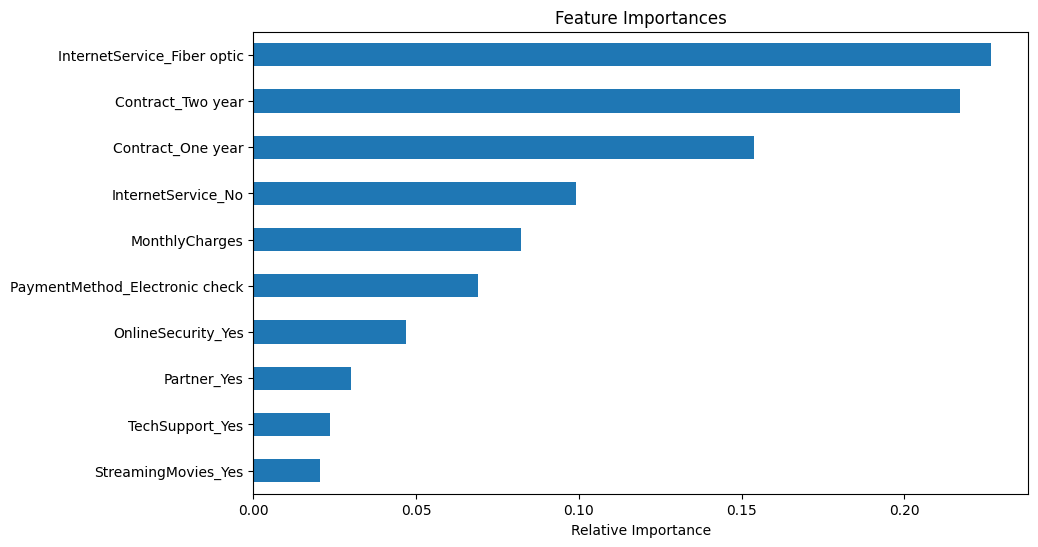

In [18]:
importances = adaboost.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

In [19]:
weights.sort_values(ascending = False) ## 从大到小排序重要性

InternetService_Fiber optic              0.226702
Contract_Two year                        0.217053
Contract_One year                        0.153955
InternetService_No                       0.099106
MonthlyCharges                           0.082113
PaymentMethod_Electronic check           0.068889
OnlineSecurity_Yes                       0.046981
Partner_Yes                              0.029958
TechSupport_Yes                          0.023592
StreamingMovies_Yes                      0.020623
PaperlessBilling_Yes                     0.016717
OnlineBackup_Yes                         0.014311
PaymentMethod_Credit card (automatic)    0.000000
SeniorCitizen                            0.000000
StreamingTV_Yes                          0.000000
DeviceProtection_Yes                     0.000000
Dependents_Yes                           0.000000
PaymentMethod_Mailed check               0.000000
dtype: float64

### 3.4 在测试集上做预测

#### 预测类别： 用predict

In [20]:
# 在测试集上做预测
y_pred = adaboost.predict(X_test)

y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
y_pred_prob = adaboost.predict_proba(X_test)
y_pred_prob

array([[0.60094296, 0.39905704],
       [0.4408603 , 0.5591397 ],
       [0.54712516, 0.45287484],
       ...,
       [0.74692644, 0.25307356],
       [0.58249593, 0.41750407],
       [0.52136454, 0.47863546]])

## 4. 评价模型

### 4.1 正确率

In [22]:
test_accuracy = adaboost.score(X_test, y_test)
print("Accuracy", round(test_accuracy,3))

Accuracy 0.775


### 4.2 精确率(precision), 召回率(recall), F1值

In [23]:
from sklearn import metrics
test_precision = metrics.precision_score(y_test, y_pred)
print("Precision", round(test_precision,3))

test_recall = metrics.recall_score(y_test, y_pred)
print("Recall:", round(test_recall,3))

test_f1 = metrics.f1_score(y_test, y_pred)
print("test_f1:", round(test_f1,3))

Precision 0.599
Recall: 0.46
test_f1: 0.521


### 4.3 混淆矩阵

In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1147,  144],
       [ 252,  215]], dtype=int64)

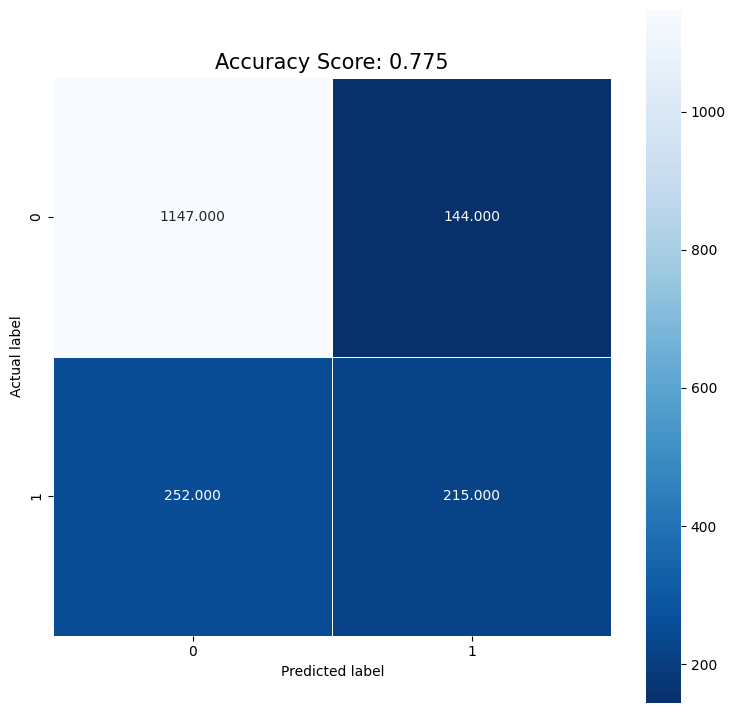

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cnf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(test_accuracy,3))
plt.title(all_sample_title, size = 15);

### 4.4 ROC和AUC

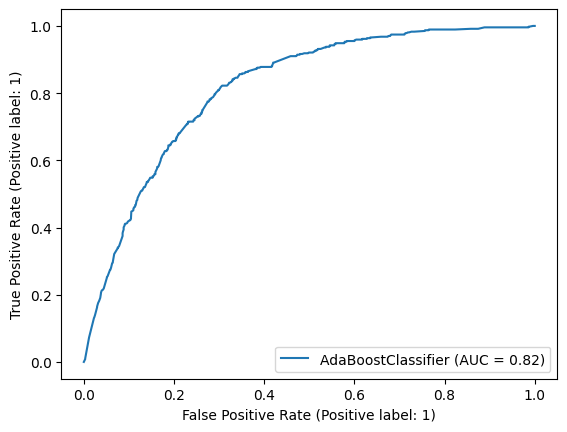

In [26]:
metrics.RocCurveDisplay.from_estimator(adaboost, X_test, y_test) 
plt.show()

## 5. GradientBoosting 分类算法


### 分类问题：使用GradientBoostingClassifier函数
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

GradientBoostingClassifier(*, loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

主要参数：

loss： 默认为’deviance’
表示训练过程中所使用的损失函数，可用选项为{‘deviance’, ‘exponential’}：

deviance表示逻辑回归损失函数；
exponential表示指数损失函数

learning_rate： 表示学习率，浮点型，默认为0.1。对GBDT分类效果的影响较大，是调参的重点对象。

n_estimators： 基学习器个数。整型，默认值为100。n_estimator太小，基学习器数量太少，容易造成欠拟合；n_estimators太大，基学习器数量太多，容易造成过拟合。在实际使用中，n_estimators的值不宜过大，也不能太小，需要通过调参找到一个合适的取值，所以这个参数也是调参的重点对象。

max_depth： 学习器（分类树）的最大深度。默认为3

max_features：基学习器划分时考虑的最大特征数。可以选择{‘auto’, ‘sqrt’, ‘log2’}, int or float，默认为None。None时，max_features=n_features，即最大特征数等于总特征数。

“auto”：max_features=n_features；

“sqrt”：max_features=sqrt(n_features)

“log2”：max_features=log2(n_features)


min_samples_split：内部节点再划分所需要的最小样本数。默认值为2

ccp_alpha：剪枝调整参数

### 5.1 加载GradientBoostingClassifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state =1)

### 5.2 在训练集上训练模型

In [28]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

### 5.3 特征重要性

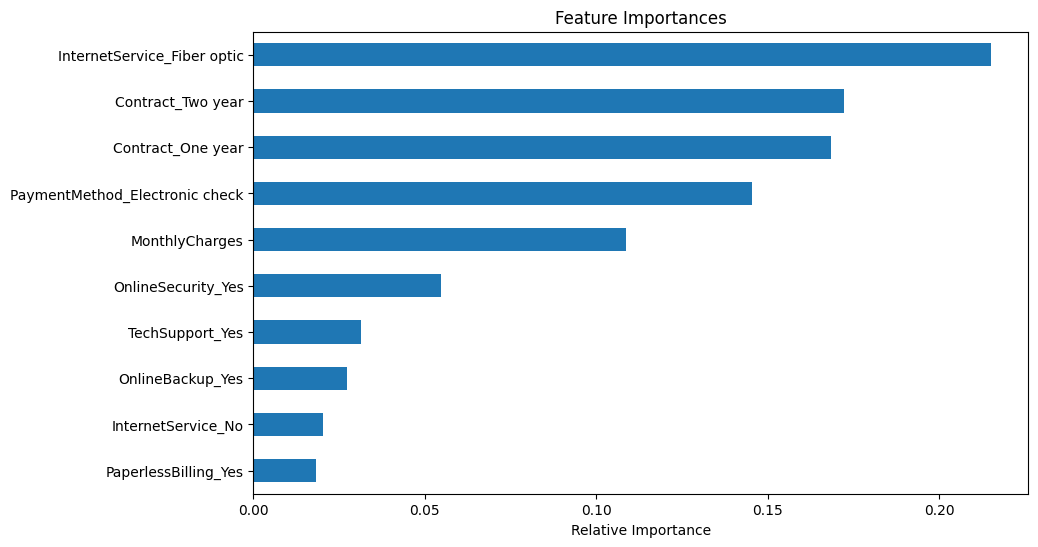

In [29]:
importances = gbc.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

In [30]:
weights.sort_values(ascending = False) ## 从大到小排序重要性

InternetService_Fiber optic              0.215166
Contract_Two year                        0.172175
Contract_One year                        0.168484
PaymentMethod_Electronic check           0.145441
MonthlyCharges                           0.108569
OnlineSecurity_Yes                       0.054829
TechSupport_Yes                          0.031283
OnlineBackup_Yes                         0.027370
InternetService_No                       0.020408
PaperlessBilling_Yes                     0.018442
Partner_Yes                              0.011631
Dependents_Yes                           0.006221
DeviceProtection_Yes                     0.005878
StreamingMovies_Yes                      0.005735
SeniorCitizen                            0.004134
PaymentMethod_Credit card (automatic)    0.002588
PaymentMethod_Mailed check               0.001035
StreamingTV_Yes                          0.000612
dtype: float64

### 5.4 在测试集上做预测

In [31]:
y_pred = gbc.predict(X_test)

y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
y_pred_prob = gbc.predict_proba(X_test)
y_pred_prob

array([[0.81512837, 0.18487163],
       [0.28715435, 0.71284565],
       [0.61894777, 0.38105223],
       ...,
       [0.98387644, 0.01612356],
       [0.84431152, 0.15568848],
       [0.62009834, 0.37990166]])

## 6. 评价Gradient Boosting分类模型

### 6.1 分类正确率

In [33]:
test_accuracy = gbc.score(X_test, y_test)
print("Accuracy", round(test_accuracy,3))

Accuracy 0.784


### 6.2 精确率、召回率、F1值

In [34]:
from sklearn import metrics
test_precision = metrics.precision_score(y_test, y_pred)
print("Precision", round(test_precision,3))

test_recall = metrics.recall_score(y_test, y_pred)
print("Recall:", round(test_recall,3))

test_f1 = metrics.f1_score(y_test, y_pred)
print("test_f1:", round(test_f1,3))

Precision 0.631
Recall: 0.448
test_f1: 0.524


### 6.3 混淆矩阵

In [35]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1169,  122],
       [ 258,  209]], dtype=int64)

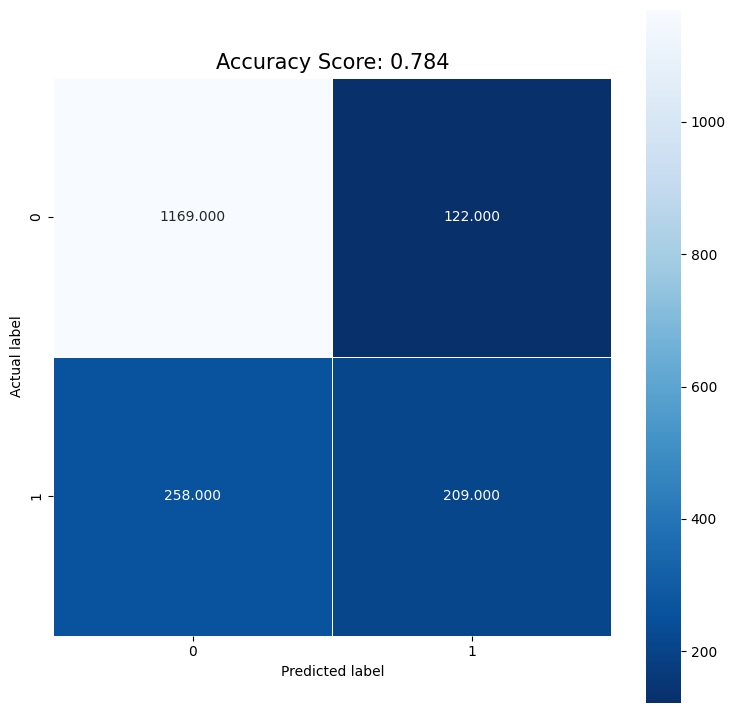

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cnf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(test_accuracy,3))
plt.title(all_sample_title, size = 15);

### 6.4 ROC和AUC

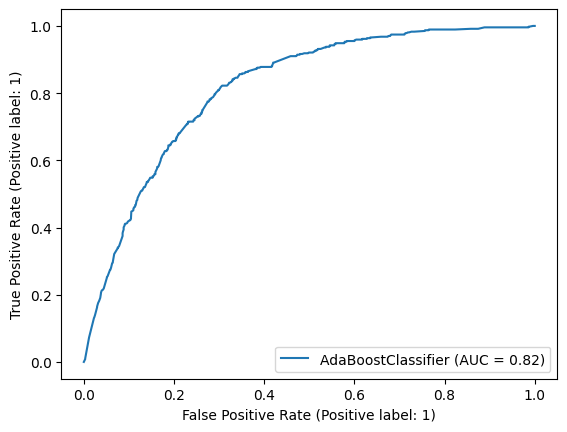

In [37]:
metrics.RocCurveDisplay.from_estimator(adaboost, X_test, y_test) 
plt.show()

## Q：如何对AdaBoost和GradientBoosting进行调参？

使用网格搜索法GridSearchCV

sklearn.model_selection.GridSearchCV(estimator, param_grid, , scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2n_jobs', error_score=nan, return_train_score=False)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimator: 代表使用的模型 param_grid: 需要最优化的参数的取值，值为字典或者列表。需要给出参数名以及参数的可能取值 scoring: 模型评价指标。在分类问题中，常见的为'accuracy','f1'(两分类),'f1_micro','f1_macro',"roc_auc"(两分类)等，更多见下方链接。 https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

cv: 交叉验证次数
    
可以考虑的参数：
n_estimators， learning_rate, max_depth, ccp_alpha等

## Q: 尝试使用AdaBoost中基分类器为逻辑回归

## Q：如何用AdaBoost解决回归问题？

使用函数 AdaBoostRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

主要参数：
base_estimator：基学习器。 默认值为None。该参数不指定时，使用DecisionTreeRegressor(max_depth=3)作为基学习器，即默认使用深度为3的回归决策树。

n_estimators: 基学习器个数。默认为50

learning_rate: 每个基学习器的权值缩减系数。默认为1

random_state: 随机种子

## Q： 如何用GradientBoosting解决回归问题？

使用函数 GradientBoostingRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor